In [0]:
!pip install wfdb
import numpy as np
import pandas as pd
import wfdb
import os
import shutil
import glob
import re
import matplotlib.pyplot as plt
from wfdb import rdrecord, rdann, processing
from sklearn.metrics import accuracy_score, f1_score
from sklearn.model_selection import train_test_split
from keras import optimizers, losses, activations, models
from keras.callbacks import ModelCheckpoint, EarlyStopping, LearningRateScheduler, ReduceLROnPlateau
from keras.layers import Dense, Input, Dropout, Convolution1D, MaxPool1D, GlobalMaxPool1D, GlobalAveragePooling1D, concatenate

     |████████████████████████████████| 102kB 2.3MB/s 
     |████████████████████████████████| 163kB 8.6MB/s 
  Created wheel for wfdb: filename=wfdb-2.2.1-cp36-none-any.whl size=100368 sha256=4eaa0305b3d2a85fc81e0de86bd8308f3b1b24a76cfb304961cf74f28b415c92
  Stored in directory: /root/.cache/pip/wheels/bb/a9/00/0078d26b0c15b31be0001af8eb659496709c361c69641303f1
Successfully built wfdb


Using TensorFlow backend.


# 1. Read the datasets from the databases
* The ECG databases: https://physionet.org/about/database/#ecg
* Convert the download the related CSV file: https://archive.physionet.org/cgi-bin/atm/ATM
* Another online tool to view the data: https://physionet.org/lightwave/
* Pay attention to the sinal resources, sampling frequency, etc. 
* the datasets include two groups: normal and anormal(chp, cogestive heart failure)
* the normal group comes from MIT-BIH Normal Sinus Rhythm Database
* the abnormal group comes from BIDMC Congestive Heart Failure Database
* download both databases and provide the path
* extract the names of the datasets for further processing

In [0]:
def read_file_names(path):
    """Extract the names of the datasets."""
    files = glob.glob(path + '*.dat')
    nums = []
    for file in files:
        file_name = os.path.basename(file)
        file_name = re.sub('.dat', '', file_name)
        nums.append(file_name)
    return nums

#Read the names of both normal and abnormal(chf) datasets.
path_normal = './dataset/mit-bih-normal/'
path_abnormal = './dataset/bidmc-chf/'
nums_normal = read_file_names(path_normal)
nums_abnormal =  read_file_names(path_abnormal)
print(nums_normal)
print(nums_abnormal)

['16265', '16272', '16273', '16420', '16483', '16539', '16773', '16786', '16795', '17052', '17453', '18177', '18184', '19088', '19090', '19093', '19140', '19830']
['chf01', 'chf02', 'chf03', 'chf04', 'chf05', 'chf06', 'chf07', 'chf08', 'chf09', 'chf10', 'chf11', 'chf12', 'chf13', 'chf14', 'chf15']


# 2. Read the ECG signal and annotation for each dataset
* separate the heartbeat of each dataset for both normal and abnormal groups
* read the corresponding annotation for all the heartbeats.
* generate the csv file, each row is the record for one heartbeat including the ecg and annotation.

In [0]:
def heartbeat_segmentation(path, nums):
    """separate the heartbeats for all the datasets"""
    signals = [] 

    for num in nums:
        print("This is dataset %s being processed..." % num)
        #Read the dataset, pick up the ecg signal channel and the length
        record = rdrecord(path + num, sampfrom=0, sampto=10000, channels=[0])

        #Detecting the qrs complexs in the dataset
        qrs_inds = processing.gqrs_detect(sig=record.p_signal[:, 0], fs=record.fs)
  
        #Correct the peaks and shift them to local maxima
        min_bpm = 20
        max_bpm = 230

        #Use the maximum possible bpm as the search radius
        search_radius = int(record.fs * 60 / max_bpm)
        peak_inds = processing.correct_peaks(record.p_signal[:,0], peak_inds=qrs_inds,
                                                       search_radius=search_radius, smooth_window_size=150)
        print("The R peaks have been obtained..." )
        
        #Segment the heartbeats in the dataset
        sig = record.p_signal[:, 0]
        count = 1
        for peak in peak_inds[1:-1]:
            diff1 = abs(peak_inds[count - 1] - peak)
            diff2 = abs(peak_inds[count + 1] - peak)
            start = peak_inds[count - 1] + diff1 // 2
            end =  peak_inds[count + 1] - diff2 // 2
            signal = sig[start: end]
            count += 1
            
            #Normalize the signal
            signal = signal - np.mean(signal)
            #Pick up the heartbeat segments and save it for further use. 
            if len(signal) < 187:
                #Read the corresponding annotation for each heartbeat
                if 'chf' in path:
                    ann = rdann(path + num, extension='ecg', sampfrom = start, sampto = end, return_label_elements=['symbol'])
                else:
                    ann = rdann(path + num, extension='atr', sampfrom = start, sampto = end, return_label_elements=['symbol'])
                ann_symbol = ann.symbol
                if len(ann_symbol) == 1 and ann_symbol[0] == 'N':
                    signal = np.concatenate([signal, np.zeros(187-len(signal))])
                    signals.append(signal)
        print("The ecg + annnotation segments have been obtained..." )
    return signals

#Save the segements of normal datasets to csv file
signals_normal = heartbeat_segmentation(path_normal, nums_normal)
df_normal = pd.DataFrame(signals_normal)
df_normal.insert(df_normal.shape[1], column='sign', value=0)
df_normal.head()
df_normal.to_csv('normal_sinus.csv', index=False)

#Save the segements of abnormal datasets to csv file
signals_abnormal = heartbeat_segmentation(path_abnormal, nums_abnormal)
df_abnormal = pd.DataFrame(signals_abnormal)
df_abnormal.insert(df_abnormal.shape[1], column='sign', value=1)
df_abnormal.to_csv('chf.csv', index=False)

This is dataset 16265 being processed...
The R peaks have been obtained...
The ecg + annnotation segments have been obtained...
This is dataset 16272 being processed...
The R peaks have been obtained...
The ecg + annnotation segments have been obtained...
This is dataset 16273 being processed...
The R peaks have been obtained...
The ecg + annnotation segments have been obtained...
This is dataset 16420 being processed...
The R peaks have been obtained...
The ecg + annnotation segments have been obtained...
This is dataset 16483 being processed...
The R peaks have been obtained...
The ecg + annnotation segments have been obtained...
This is dataset 16539 being processed...
The R peaks have been obtained...
The ecg + annnotation segments have been obtained...
This is dataset 16773 being processed...
The R peaks have been obtained...
The ecg + annnotation segments have been obtained...
This is dataset 16786 being processed...
The R peaks have been obtained...
The ecg + annnotation segment

# 3. Visualize the heartbeats 
* visulize and check the data before further processing
* the pattern of the normal and chf ecg signals are very different

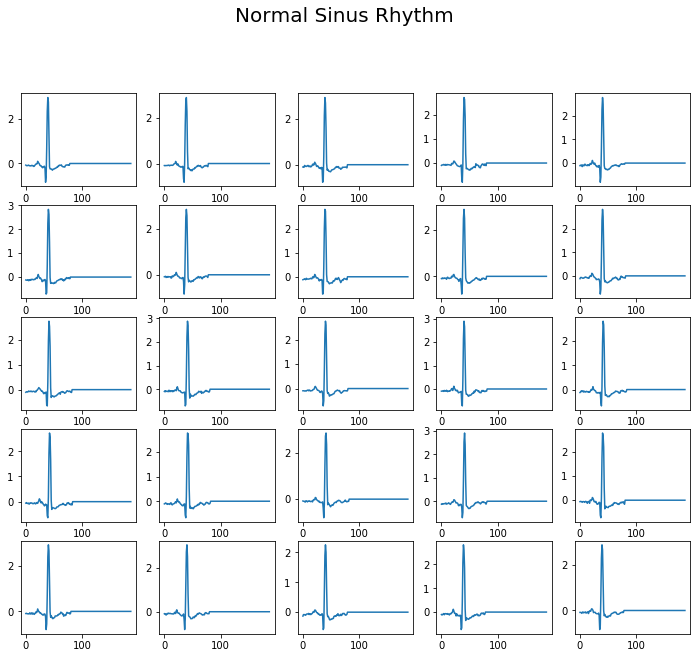

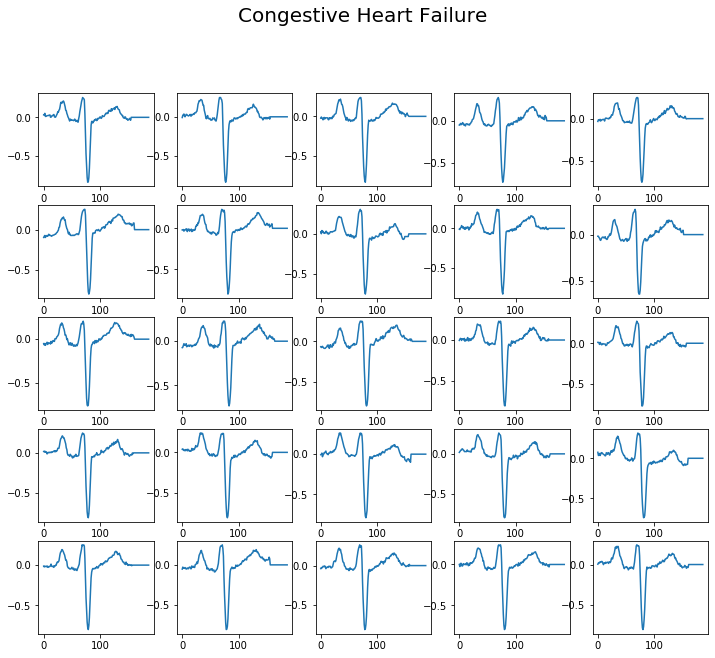

In [0]:
def plot_segments(signals, title):
    """visualize the heartbeats extracted above"""
    plt.figure(figsize=(12, 12))
    col_num = 5
    signal_nums = 25
    row_num = len(signals[:signal_nums]) / col_num + 1
    for i in range(len(signals[:signal_nums])):
        plt.subplot(row_num, col_num, i+1)
        plt.plot(signals[i])
    plt.suptitle(title, size=20) 
    plt.show()

#Plot the normal and abnormal signals respectively
plot_segments(signals_normal, 'Normal Sinus Rhythm')
plot_segments(signals_abnormal, 'Congestive Heart Failure')

#  4.Prepare the trainning and test datasets
* generate the training and test datasets
* review the dataframe to make sure everything looks correct. 

In [0]:
df_normal = pd.read_csv("./normal_sinus.csv", skiprows=[0], header=None)
df_normal.describe

<bound method NDFrame.describe of            0         1         2         3         4         5         6    \
0    -0.072179 -0.092179 -0.102179 -0.092179 -0.082179 -0.072179 -0.102179   
1    -0.088462 -0.098462 -0.088462 -0.088462 -0.088462 -0.088462 -0.078462   
2    -0.100759 -0.110759 -0.110759 -0.030759 -0.060759 -0.070759 -0.080759   
3    -0.098625 -0.078625 -0.078625 -0.078625 -0.058625 -0.068625 -0.088625   
4    -0.108000 -0.108000 -0.078000 -0.088000 -0.148000 -0.078000 -0.098000   
...        ...       ...       ...       ...       ...       ...       ...   
1516  0.004521  0.004521 -0.005479 -0.015479 -0.035479 -0.005479 -0.005479   
1517  0.010946  0.000946  0.000946 -0.029054 -0.029054 -0.039054 -0.029054   
1518  0.020533  0.000533 -0.009467  0.010533 -0.019467 -0.029467  0.030533   
1519  0.028684 -0.031316 -0.041316 -0.011316  0.008684 -0.051316 -0.021316   
1520 -0.058158 -0.058158 -0.058158 -0.038158 -0.068158 -0.068158 -0.108158   

           7         8       

In [0]:
df_abnormal = pd.read_csv("./chf.csv", skiprows=[0], header=None)
df_abnormal.describe

<bound method NDFrame.describe of           0         1         2         3         4         5         6    \
0    0.032032  0.027032  0.052032  0.012032  0.012032  0.017032  0.022032   
1   -0.009487  0.020513  0.025513  0.035513  0.005513  0.000513  0.015513   
2   -0.023429 -0.008429 -0.023429 -0.023429 -0.043429 -0.023429 -0.013429   
3   -0.051258 -0.051258 -0.031258 -0.036258 -0.046258 -0.031258 -0.021258   
4   -0.033354 -0.013354 -0.013354 -0.023354 -0.008354 -0.028354 -0.018354   
..        ...       ...       ...       ...       ...       ...       ...   
674 -0.090714 -0.085714 -0.095714 -0.150714 -0.165714 -0.160714 -0.135714   
675 -0.706745 -0.711745 -0.716745 -0.706745 -0.686745 -0.671745 -0.646745   
676 -0.814367 -0.799367 -0.754367 -0.749367 -0.759367 -0.759367 -0.804367   
677 -0.886644 -0.866644 -0.851644 -0.826644 -0.696644 -0.626644 -0.666644   
678 -1.028600 -1.013600 -1.003600 -0.993600 -0.943600 -0.958600 -1.013600   

          7         8         9    ...  1

In [0]:
#combine the normal and chf datasets and generate the training and test datasets
df = pd.concat([df_normal, df_abnormal])
df_train, df_test = train_test_split(df, test_size=0.2)
df.head()

,0,1,2,3,4,5,6,7,8,9,...,178,179,180,181,182,183,184,185,186,187
0,-0.072179,-0.092179,-0.102179,-0.092179,-0.082179,-0.072179,-0.102179,-0.102179,-0.102179,-0.112179,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
1,-0.088462,-0.098462,-0.088462,-0.088462,-0.088462,-0.088462,-0.078462,-0.078462,-0.068462,-0.098462,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
2,-0.100759,-0.110759,-0.110759,-0.030759,-0.060759,-0.070759,-0.080759,-0.060759,-0.050759,-0.030759,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
3,-0.098625,-0.078625,-0.078625,-0.078625,-0.058625,-0.068625,-0.088625,-0.058625,-0.078625,-0.088625,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
4,-0.108000,-0.108000,-0.078000,-0.088000,-0.148000,-0.078000,-0.098000,-0.118000,-0.058000,-0.048000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0


In [0]:
x_train = np.array(df_train[list(range(187))].values)[..., np.newaxis]
y_train = np.array(df_train[187].values).astype(np.int8)
x_test = np.array(df_test[list(range(187))].values)[..., np.newaxis]
y_test = np.array(df_test[187].values).astype(np.int8)

# 4. Build the CNN model
* Train the model
* Save the model

In [0]:
def cnn_model():
    nclass = 1
    inp = Input(shape=(187, 1))
    img_1 = Convolution1D(16, kernel_size=5, activation=activations.relu, padding="valid")(inp)
    img_1 = Convolution1D(16, kernel_size=5, activation=activations.relu, padding="valid")(img_1)
    img_1 = MaxPool1D(pool_size=2)(img_1)
    img_1 = Dropout(rate=0.1)(img_1)
    img_1 = Convolution1D(32, kernel_size=3, activation=activations.relu, padding="valid")(img_1)
    img_1 = Convolution1D(32, kernel_size=3, activation=activations.relu, padding="valid")(img_1)
    img_1 = MaxPool1D(pool_size=2)(img_1)
    img_1 = Dropout(rate=0.1)(img_1)
    img_1 = Convolution1D(32, kernel_size=3, activation=activations.relu, padding="valid")(img_1)
    img_1 = Convolution1D(32, kernel_size=3, activation=activations.relu, padding="valid")(img_1)
    img_1 = MaxPool1D(pool_size=2)(img_1)
    img_1 = Dropout(rate=0.1)(img_1)
    img_1 = Convolution1D(256, kernel_size=3, activation=activations.relu, padding="valid")(img_1)
    img_1 = Convolution1D(256, kernel_size=3, activation=activations.relu, padding="valid")(img_1)
    img_1 = GlobalMaxPool1D()(img_1)
    img_1 = Dropout(rate=0.2)(img_1)

    dense_1 = Dense(64, activation=activations.relu, name="dense_1")(img_1)
    dense_1 = Dense(64, activation=activations.relu, name="dense_2")(dense_1)
    dense_1 = Dense(nclass, activation=activations.sigmoid, name="dense_3_ptbdb")(dense_1)

    model = models.Model(inputs=inp, outputs=dense_1)
    opt = optimizers.Adam(0.001)

    model.compile(optimizer=opt, loss=losses.binary_crossentropy, metrics=['acc'])
    model.summary()
    return model

model = cnn_model()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 187, 1)            0         
_________________________________________________________________
conv1d_9 (Conv1D)            (None, 183, 16)           96        
_________________________________________________________________
conv1d_10 (Conv1D)           (None, 179, 16)           1296      
_________________________________________________________________
max_pooling1d_4 (MaxPooling1 (None, 89, 16)            0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 89, 16)            0         
_________________________________________________________________
conv1d_11 (Conv1D)           (None, 87, 32)            1568      
_________________________________________________________________
conv1d_12 (Conv1D)           (None, 85, 32)            3104      
__________

In [0]:
file_path = "CHF_detection.h5"
checkpoint = ModelCheckpoint(file_path, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
early = EarlyStopping(monitor="val_acc", mode="max", patience=5, verbose=1)
redonplat = ReduceLROnPlateau(monitor="val_acc", mode="max", patience=3, verbose=2)
callbacks_list = [checkpoint, early, redonplat]

model.fit(x_train, y_train, epochs=30, verbose=2, callbacks=callbacks_list, validation_split=0.1)
model.load_weights(file_path)

Train on 1584 samples, validate on 176 samples
Epoch 1/30
 - 2s - loss: 0.0123 - acc: 0.9968 - val_loss: 0.0030 - val_acc: 1.0000

Epoch 00001: val_acc improved from -inf to 1.00000, saving model to CHF_detection.h5
Epoch 2/30
 - 2s - loss: 0.0133 - acc: 0.9956 - val_loss: 0.0021 - val_acc: 1.0000

Epoch 00002: val_acc did not improve from 1.00000
Epoch 3/30
 - 2s - loss: 0.0064 - acc: 0.9981 - val_loss: 0.0023 - val_acc: 1.0000

Epoch 00003: val_acc did not improve from 1.00000
Epoch 4/30
 - 2s - loss: 0.0072 - acc: 0.9981 - val_loss: 0.0015 - val_acc: 1.0000

Epoch 00004: val_acc did not improve from 1.00000

Epoch 00004: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.
Epoch 5/30
 - 1s - loss: 0.0048 - acc: 0.9981 - val_loss: 0.0016 - val_acc: 1.0000

Epoch 00005: val_acc did not improve from 1.00000
Epoch 6/30
 - 2s - loss: 0.0057 - acc: 0.9981 - val_loss: 0.0017 - val_acc: 1.0000

Epoch 00006: val_acc did not improve from 1.00000
Epoch 00006: early stopping


In [0]:
pred_test = model.predict(x_test)
pred_test = (pred_test > 0.5).astype(np.int8)

f1 = f1_score(y_test, pred_test)
print("Test f1 score : %s "% f1)

acc = accuracy_score(y_test, pred_test)
print("Test accuracy score : %s "% acc)

Test f1 score : 0.9930555555555556 
Test accuracy score : 0.9954545454545455 
